# Decoders

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import Counter
from tqdm.auto import tqdm
from tqdm import tqdm

from transformers import (
    GPT2LMHeadModel, 
    GPT2Tokenizer,
    AutoModelForCausalLM,
    AutoTokenizer
)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)


## 0. Model definitions and loading:

The decoder models to be used are:

- GPT-2 (124M parameters)
- GPT-2-XL (1.5B parameters)
- Gemma2 (2B parameters)

This section loads the models and defines the generation functions.

In [ ]:
!pip install --index-url https://download.pytorch.org/whl/cu121 torch

In [ ]:
!pip install transformers scikit-learn pandas numpy tqdm matplotlib seaborn -q

In [ ]:
# === Gemma 2 (≤7B) setup via Hugging Face Transformers (PyTorch) ===
# Requisitos:
!pip install -U accelerate bitsandbytes torch

/home/admonsis/.venv-1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]


In [ ]:

import os, torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = os.environ.get("GEMMA2_MODEL_ID", "google/gemma-2-2b")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

def gemma2_generate(prompt, max_new_tokens=128, temperature=0.7, top_p=0.95):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


## 1. Preprocessing Functions (from the encoder notebook)

These functions clean the texts by removing:

* **20Newsgroups**: Email headers, email addresses, URLs, signatures, quoted lines
* **Multi-Domain Sentiment**: Underscores, special tokens such as `<num>`

In [ ]:
def clean_20_news(text: str) -> str:
    """
    Cleans a 20 Newsgroups document by removing email metadata and artifacts.
    
    Steps:
    1. Removes common email headers (From, Subject, Organization, etc.)
    2. Deletes email addresses and URLs using regex
    3. Removes signature lines and separators ('--', '__')
    4. Removes quoted lines starting with '>' or ':'
    5. Collapses multiple newlines and spaces for consistent formatting
    
    Args:
        text: Raw email or newsgroup message text
        
    Returns:
        Clean text containing only meaningful content
    """
    # Remove common email headers
    text = re.sub(r'^(From|Subject|Lines|Organization|Reply-To|NNTP-Posting-Host|Keywords|Summary):.*$', 
                  '', text, flags=re.MULTILINE)
    
    # Remove email addresses and URLs
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove signature lines or separators
    text = re.sub(r'--+\s*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'_+', '', text)
    
    # Remove quoted lines (starting with > or :)
    text = re.sub(r'(^>.*$|^:.*$)', '', text, flags=re.MULTILINE)
    
    # Collapse multiple newlines and spaces
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


def clean_multidomain(text: str) -> str:
    """
    Simplifies review text from the Multi-Domain Sentiment dataset.
    
    Steps:
    1. Replaces underscores with spaces to normalize tokens
    2. Removes placeholder tokens like '<num>'
    3. Eliminates redundant spaces
    
    Args:
        text: Raw dataset text
        
    Returns:
        Clean version of the text
    """
    # Replace underscores with spaces
    text = text.replace("_", " ")
    
    # Remove special tokens like <num>
    text = re.sub(r"<num>", "", text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


## 2. Loading Datasets with Preprocessing

### 2.1 20Newsgroups Dataset

In [ ]:
class NewsGroupsLoader:
    """
    Class for loading and processing the 20Newsgroups dataset with enhanced cleaning.
    """
    
    def __init__(self, root_path: str):
        """
        Initializes the loader.
        
        Args:
            root_path: Path to the dataset’s root directory
        """
        self.root_path = Path(root_path)
        self.categories = self._get_categories()
        
    def _get_categories(self) -> List[str]:
        """
        Retrieves the list of dataset categories.
        
        Returns:
            Sorted list of category names
        """
        categories = [d.name for d in self.root_path.iterdir() if d.is_dir()]
        return sorted(categories)
    
    def load_data(self, max_samples_per_category: Optional[int] = None) -> Tuple[List[str], List[str]]:
        """
        Loads dataset samples with automatic cleaning.
        
        Args:
            max_samples_per_category: Maximum number of samples per category
            
        Returns:
            Tuple (clean_texts, labels)
        """
        texts = []
        labels = []
        
        print(f"Loading 20Newsgroups from: {self.root_path}")
        print(f"Categories found: {len(self.categories)}")
        
        for category in tqdm(self.categories, desc="Processing categories"):
            category_path = self.root_path / category
            files = list(category_path.glob('*'))
            
            if max_samples_per_category:
                files = files[:max_samples_per_category]
            
            for file_path in files:
                if file_path.is_file():
                    try:
                        # Read file with encoding handling
                        with open(file_path, 'rb') as f:
                            raw = f.read()
                        
                        try:
                            text = raw.decode('utf-8').strip()
                        except UnicodeDecodeError:
                            text = raw.decode('latin-1').strip()
                        
                        # APPLY CLEANING
                        cleaned_text = clean_20_news(text)
                        
                        # Only add if content remains after cleaning
                        if cleaned_text and len(cleaned_text) > 50:
                            texts.append(cleaned_text)
                            labels.append(category)
                            
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
        
        print(f"\nTotal loaded documents: {len(texts)}")
        print(f"Category distribution:")
        label_counts = Counter(labels)
        for label, count in sorted(label_counts.items()):
            print(f"  {label}: {count}")
        
        return texts, labels


### 2.2 Dataset Multi-Domain Sentiment

In [ ]:
class MultiDomainSentimentLoader:
    """
    Class for loading and processing the Multi-Domain Sentiment Dataset with enhanced cleaning.
    """
    
    def __init__(self, root_path: str):
        """
        Initializes the loader.
        
        Args:
            root_path: Path to the dataset’s root directory
        """
        self.root_path = Path(root_path)
        self.domains = ['books', 'dvd', 'electronics', 'kitchen']
        
    def _parse_review_line(self, line: str) -> Tuple[str, str]:
        """
        Parses a review line from the file.
        
        Format: word1:freq1 word2:freq2 ... #label#:positive/negative
        
        Args:
            line: Line of the file
            
        Returns:
            Tuple (reconstructed_text, label)
        """
        parts = line.strip().split()
        
        label = None
        words = []
        
        for part in parts:
            if part.startswith('#label#:'):
                label = part.split(':')[1]
            else:
                if ':' in part:
                    word, freq = part.rsplit(':', 1)
                    try:
                        freq = int(freq)
                        # Simplification: use each word once
                        words.append(word)
                    except ValueError:
                        continue
        
        # Reconstruct text
        text = ' '.join(words)
        
        # APPLY CLEANING
        cleaned_text = clean_multidomain(text)
        
        return cleaned_text, label
    
    def load_domain_data(self, domain: str, sentiment: str, 
                         max_samples: Optional[int] = None) -> Tuple[List[str], List[str]]:
        """
        Loads data for a specific domain and sentiment.
        
        Args:
            domain: Domain name
            sentiment: Sentiment type ('positive' or 'negative')
            max_samples: Maximum number of samples to load
            
        Returns:
            Tuple (clean_texts, labels)
        """
        file_path = self.root_path / domain / f"{sentiment}.review"
        
        texts = []
        labels = []
        
        if not file_path.exists():
            print(f"Warning: {file_path} not found")
            return texts, labels
        
        with open(file_path, 'r', encoding='latin-1') as f:
            lines = f.readlines()
            
            if max_samples:
                lines = lines[:max_samples]
            
            for line in lines:
                text, label = self._parse_review_line(line)
                if text and label and len(text) > 20:  # Filter very short texts
                    texts.append(text)
                    labels.append(label)
        
        return texts, labels
    
    def load_all_data(self, max_samples_per_sentiment: Optional[int] = None) -> Tuple[List[str], List[str], List[str]]:
        """
        Loads all data from all domains.
        
        Args:
            max_samples_per_sentiment: Maximum samples per sentiment in each domain
            
        Returns:
            Tuple (clean_texts, labels, domains)
        """
        all_texts = []
        all_labels = []
        all_domains = []
        
        print(f"Loading Multi-Domain Sentiment from: {self.root_path}")
        
        for domain in tqdm(self.domains, desc="Processing domains"):
            for sentiment in ['positive', 'negative']:
                texts, labels = self.load_domain_data(domain, sentiment, max_samples_per_sentiment)
                all_texts.extend(texts)
                all_labels.extend(labels)
                all_domains.extend([domain] * len(texts))
                
                print(f"  {domain}/{sentiment}: {len(texts)} samples")
        
        print(f"\nTotal reviews loaded: {len(all_texts)}")
        print(f"Sentiment distribution:")
        label_counts = Counter(all_labels)
        for label, count in label_counts.items():
            print(f"  {label}: {count}")
        
        return all_texts, all_labels, all_domains


## 3. Classifier Implementations

This class uses preprocessed texts for improved classification. Here we implement both a class for GPT-2 and another for Gemma2.

Given the extremely poor baseline performance of decoder-only models on the 20Newsgroups dataset—where GPT-2 (124M) and GPT-2-XL (1.5B) achieved accuracies close to random guessing,prompt engineering became essential to guide the model toward the actual classification task. The prompts were redesigned to include three core elements: (1) a minimal task-specific context describing the dataset and the type of text the model would receive, (2) short, carefully selected few-shot examples to anchor the expected output format, and (3) concise phrasing to avoid unnecessary token consumption and to preserve space within the limited context window of decoder-only models. 

The contextual description helps the model understand that 20Newsgroups posts correspond to forum discussions across specific topical categories, which is not obvious from the raw text alone. The few-shot examples provide explicit demonstrations of how a message maps to a category, reducing ambiguity and forcing the model to mimic the desired output format. Finally, keeping the instructions short ensures that the prompt remains efficient and that the classifier focuses on the essential classification signal rather than being overwhelmed by long instructions or excessive examples. These design decisions directly address the observed failures and aim to improve the model’s ability to distinguish between the highly heterogeneous categories in 20Newsgroups.

Below are the previous results obtained without the prompt improvements listed above:

| Model           | Preprocessing | Task         | Accuracy | F1 Macro | F1 Micro |
| --------------- | ------------- | ------------ | -------- | -------- | -------- |
| GPT-2 (124M)    | With cleaning | Sentiment    | 0.501250 | 0.336105 | 0.501250 |
| GPT-2-XL (1.5B) | With cleaning | Sentiment    | 0.500000 | 0.333333 | 0.500000 |
| GPT-2 (124M)    | With cleaning | 20Newsgroups | 0.056509 | 0.029406 | 0.056509 |
| GPT-2-XL (1.5B) | With cleaning | 20Newsgroups | 0.058527 | 0.029013 | 0.058527 |


In [ ]:
class GPT2Classifier:
    """
    Classifier based on GPT-2 models using prompting without fine-tuning.
    
    It now uses PREPROCESSED texts for better performance.
    """
    
    def __init__(self, model_name: str = "gpt2", device: str = "cuda"):
        """
        Initializes the GPT-2 classifier.
        
        Args:
            model_name: GPT-2 model name ('gpt2', 'gpt2-xl')
            device: Device to run the model on
        """
        print(f"\nLoading model: {model_name}")
        self.model_name = model_name
        self.device = device
        
        # Load model and tokenizer
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.to(device)
        self.model.eval()
        
        # Configure pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        print(f"Model successfully loaded on {device}")
        print(f"Number of parameters: {self.model.num_parameters() / 1e6:.1f}M")
    
    def create_prompt(self, text: str, task_type: str, categories: List[str] = None) -> str:
        """
        Creates an improved task-specific classification prompt with dataset context,
        short examples, and clearer instructions.
        """

        # Truncate long texts
        max_text_length = 512
        if len(text) > max_text_length:
            text = text[:max_text_length] + "..."

        # -----------------------------
        # SENTIMENT ANALYSIS (MDSD)
        # -----------------------------
        if task_type == 'sentiment':
            prompt = (
                "You will classify product reviews from the Multi-Domain Sentiment Dataset.\n"
                "Each review expresses either a positive or a negative opinion.\n"
                "A positive review indicates satisfaction, good quality, or a good experience.\n"
                "A negative review indicates dissatisfaction, poor quality, or a bad experience.\n"
                "Respond using only the words 'positive' or 'negative'.\n\n"
                "Example:\n"
                "Review: The product arrived broken and stopped working immediately.\n"
                "Sentiment: negative\n\n"
                "Example:\n"
                "Review: Excellent quality, works perfectly and exceeded expectations.\n"
                "Sentiment: positive\n\n"
                f"Review: {text}\n"
                "Sentiment:"
            )

        # -----------------------------
        # 20 NEWSGROUPS
        # -----------------------------
        elif task_type == 'newsgroups':

            if not categories or len(categories) == 0:
                raise ValueError("Categories list is required for newsgroups classification.")

            # Usenet context + instruction to answer with 1 label
            prompt = (
                "You will classify a message from the 20 Newsgroups dataset.\n"
                "These messages come from online forum discussions (Usenet) across different topics.\n"
                "Your task is to identify the single category that best matches the main topic.\n"
                "Respond using only one category name from the list.\n\n"
                "Example:\n"
                "Message: I installed the new drivers for my video card and now my system keeps freezing.\n"
                "Category: comp.os.ms-windows.misc\n\n"
                "Available categories:\n"
                f"{', '.join(categories)}\n\n"
                f"Message: {text}\n"
                "Category:"
            )

        else:
            raise ValueError(f"Unsupported task type: {task_type}")

        return prompt

    
    def generate_completion(self, prompt: str, max_new_tokens: int = 20) -> str:
        """
        Generates a completion for the given prompt.
        
        Args:
            prompt: Input prompt
            max_new_tokens: Maximum number of tokens to generate
            
        Returns:
            Generated text
        """
        with torch.no_grad():
            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1,
                pad_token_id=self.tokenizer.eos_token_id,
                do_sample=False,
                temperature=1.0
            )
            
            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            completion = generated_text[len(prompt):].strip()
            
        return completion
    
    def extract_label_from_completion(self, completion: str, valid_labels: List[str], 
                                     task_type: str = 'sentiment') -> str:
        """
        Extracts the predicted label from the generated text.
        
        Args:
            completion: Generated model output
            valid_labels: List of valid labels
            task_type: Task type
            
        Returns:
            Extracted label
        """
        completion_lower = completion.lower()
        first_line = completion.split('\n')[0]
        first_words = ' '.join(first_line.split()[:5]).lower()
        
        if task_type == 'sentiment':
            if 'positive' in first_words or 'good' in first_words or 'great' in first_words:
                return 'positive'
            elif 'negative' in first_words or 'bad' in first_words or 'poor' in first_words:
                return 'negative'
            else:
                first_word = first_line.split()[0].lower() if first_line.split() else ''
                if 'pos' in first_word:
                    return 'positive'
                elif 'neg' in first_word:
                    return 'negative'
                else:
                    return 'positive'
        
        else:  # newsgroups
            for label in valid_labels:
                label_parts = label.split('.')
                for part in label_parts:
                    if part.lower() in first_words:
                        return label
            
            best_match = None
            max_overlap = 0
            
            for label in valid_labels:
                label_words = set(label.lower().replace('.', ' ').split())
                completion_words = set(first_words.split())
                overlap = len(label_words & completion_words)
                
                if overlap > max_overlap:
                    max_overlap = overlap
                    best_match = label
            
            return best_match if best_match else valid_labels[0]
    
    def predict(self, texts: List[str], task_type: str, 
                valid_labels: List[str], batch_size: int = 1) -> List[str]:
        """
        Predicts labels for a list of clean texts.
        
        Args:
            texts: List of CLEAN texts to classify
            task_type: Type of task
            valid_labels: List of valid labels
            batch_size: Batch size
            
        Returns:
            List of predictions
        """
        predictions = []
        
        print(f"\nRunning predictions with {self.model_name}...")
        
        for text in tqdm(texts, desc="Classifying"):
            prompt = self.create_prompt(text, task_type, valid_labels)
            completion = self.generate_completion(prompt)
            label = self.extract_label_from_completion(completion, valid_labels, task_type)
            predictions.append(label)
        
        return predictions


In [ ]:
class Gemma2Classifier:
    """
    Classifier based on prompting without fine-tuning.
    Compatible with Gemma 2 (2B/2B-it) loaded via Transformers.
    Preserves the same prompt style and label extraction logic
    as the original GPT-2 snippet.
    """

    def __init__(
        self,
        model_name: str = None,
        device: str = None,
        tokenizer: AutoTokenizer = None,
        model: AutoModelForCausalLM = None,
    ):
        """
        Args:
            model_name: HF model ID (e.g. "google/gemma-2-2b" or "google/gemma-2-2b-it").
            device: "cuda" or "cpu" (if None, auto-detect).
            tokenizer: Optional preloaded tokenizer.
            model: Optional preloaded model.
        """
        # Device selection
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"

        # Reuse provided or global objects
        if tokenizer is not None and model is not None:
            self.tokenizer = tokenizer
            self.model = model
            self.model_name = getattr(model.config, "name_or_path", "gemma2")
        else:
            if "tokenizer" in globals() and "model" in globals():
                self.tokenizer = globals()["tokenizer"]
                self.model = globals()["model"]
                self.model_name = getattr(self.model.config, "name_or_path", "gemma2")
            else:
                if model_name is None:
                    model_name = "google/gemma-2-2b"
                print(f"\nLoading model: {model_name}")
                self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
                self.model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    trust_remote_code=True
                )

        self.device = device
        self.model.to(self.device)
        self.model.eval()

        # Ensure pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print(f"Model '{self.model_name}' ready on {self.device}")
        try:
            print(f"Number of parameters: {self.model.num_parameters() / 1e6:.1f}M")
        except Exception:
            pass

    def create_prompt(self, text: str, task_type: str, categories: List[str] = None) -> str:
        """
        Creates an improved task-specific classification prompt with dataset context,
        short examples, and clearer instructions.
        """

        # Truncate long texts
        max_text_length = 350
        if len(text) > max_text_length:
            text = text[:max_text_length] + "..."

        # -----------------------------
        # SENTIMENT ANALYSIS (MDSD)
        # -----------------------------
        if task_type == 'sentiment':
            prompt = (
                "You will classify product reviews from the Multi-Domain Sentiment Dataset.\n"
                "Each review expresses either a positive or a negative opinion.\n"
                "A positive review indicates satisfaction, good quality, or a good experience.\n"
                "A negative review indicates dissatisfaction, poor quality, or a bad experience.\n"
                "Respond using only the words 'positive' or 'negative'.\n\n"
                "Example:\n"
                "Review: The product arrived broken and stopped working immediately.\n"
                "Sentiment: negative\n\n"
                "Example:\n"
                "Review: Excellent quality, works perfectly and exceeded expectations.\n"
                "Sentiment: positive\n\n"
                f"Review: {text}\n"
                "Sentiment:"
            )

        # -----------------------------
        # 20 NEWSGROUPS
        # -----------------------------
        elif task_type == 'newsgroups':

            if not categories or len(categories) == 0:
                raise ValueError("Categories list is required for newsgroups classification.")

            # Usenet context + instruction to answer with 1 label
            prompt = (
                "You will classify a message from the 20 Newsgroups dataset.\n"
                "These messages come from online forum discussions (Usenet) across different topics.\n"
                "Your task is to identify the single category that best matches the main topic.\n"
                "Respond using only one category name from the list.\n\n"
                "Example:\n"
                "Message: I installed the new drivers for my video card and now my system keeps freezing.\n"
                "Category: comp.os.ms-windows.misc\n\n"
                "Available categories:\n"
                f"{', '.join(categories)}\n\n"
                f"Message: {text}\n"
                "Category:"
            )

        else:
            raise ValueError(f"Unsupported task type: {task_type}")

        return prompt


    def generate_completion(self, prompt: str, max_new_tokens: int = 20) -> str:
        """
        Generates continuation for the given prompt (greedy decoding,
        same behavior as the original implementation).
        """
        with torch.no_grad():
            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1,
                pad_token_id=self.tokenizer.eos_token_id,
                do_sample=False,
                temperature=1.0
            )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        if generated_text.startswith(prompt):
            completion = generated_text[len(prompt):].strip()
        else:
            anchor = "Category:" if "Category:" in prompt else "Sentiment:"
            completion = generated_text.split(anchor)[-1].strip()

        return completion

    def extract_label_from_completion(
        self,
        completion: str,
        valid_labels: List[str],
        task_type: str = "sentiment"
    ) -> str:
        """
        Extracts the label from the first line/words of the output.
        Same logic as the original snippet.
        """
        first_line = completion.split("\n")[0]
        first_words = " ".join(first_line.split()[:5]).lower()

        if task_type == "sentiment":
            if any(x in first_words for x in ["positive", "good", "great"]):
                return "positive"
            if any(x in first_words for x in ["negative", "bad", "poor"]):
                return "negative"
            first_word = first_line.split()[0].lower() if first_line.split() else ""
            if "pos" in first_word:
                return "positive"
            if "neg" in first_word:
                return "negative"
            return "positive"

        else:  # newsgroups
            for label in valid_labels:
                for part in label.split("."):
                    if part.lower() in first_words:
                        return label

            best_match, max_overlap = None, 0
            completion_words = set(first_words.split())
            for label in valid_labels:
                label_words = set(label.lower().replace(".", " ").split())
                overlap = len(label_words & completion_words)
                if overlap > max_overlap:
                    max_overlap = overlap
                    best_match = label

            return best_match if best_match else valid_labels[0]

    def predict(
        self,
        texts: List[str],
        task_type: str,
        valid_labels: List[str],
        batch_size: int = 1
    ) -> List[str]:
        """
        Classifies a list of clean texts using prompting.
        """
        predictions = []
        print(f"\nRunning predictions with {getattr(self.model.config, 'name_or_path', 'gemma2')}...")

        for text in tqdm(texts, desc="Classifying"):
            prompt = self.create_prompt(text, task_type, valid_labels)
            completion = self.generate_completion(prompt)
            label = self.extract_label_from_completion(completion, valid_labels, task_type)
            predictions.append(label)

        return predictions

## 4. Evaluation Functions


In [ ]:
def evaluate_classifier(y_true: List[str], y_pred: List[str], 
                       label_names: List[str] = None) -> Dict:
    """
    Evaluates classifier performance.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        label_names: Label names
        
    Returns:
        Dictionary with metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    
    report = classification_report(y_true, y_pred, target_names=label_names, zero_division=0)
    
    results = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'report': report
    }
    
    return results


def print_results(results: Dict, model_name: str, task_name: str):
    """
    Prints evaluation results.
    """
    print(f"\n{'='*80}")
    print(f"Results: {model_name} - {task_name}")
    print(f"{'='*80}")
    print(f"\nAccuracy: {results['accuracy']:.4f}")
    print(f"\nMacro Metrics:")
    print(f"  Precision: {results['precision_macro']:.4f}")
    print(f"  Recall:    {results['recall_macro']:.4f}")
    print(f"  F1-Score:  {results['f1_macro']:.4f}")
    print(f"\nMicro Metrics:")
    print(f"  Precision: {results['precision_micro']:.4f}")
    print(f"  Recall:    {results['recall_micro']:.4f}")
    print(f"  F1-Score:  {results['f1_micro']:.4f}")
    print(f"\nClassification Report:")
    print(results['report'])


## 5. Experiments

The experiments consisted of evaluating decoder-only language models on two text classification tasks using cleaned versions of the Multi-Domain Sentiment dataset and the 20Newsgroups corpus. For each dataset, three models were tested: GPT-2 (124M), GPT-2-XL (1.5B), and Gemma-2, all used without fine-tuning and relying solely on prompting. The procedure involved loading and preprocessing the datasets, generating predictions through task-specific prompts, and computing standard evaluation metrics including accuracy and F1 scores.

### 5.1 Path Configuration

In [10]:
# CONFIGURACIÓN
NEWSGROUPS_PATH = "20news-18828"  
SENTIMENT_PATH = "processed_acl"  

# Parámetros para limitar el tamaño (ajustar según recursos)
MAX_SAMPLES_NEWSGROUPS = 50  # Por categoría
MAX_SAMPLES_SENTIMENT = 100  # Por sentimiento/dominio

# Para experimento completo:
# MAX_SAMPLES_NEWSGROUPS = None
# MAX_SAMPLES_SENTIMENT = None

### 5.2 Load Data (with automatic cleaning)

In [12]:
# Cargar Multi-Domain Sentiment con limpieza
print("\n" + "="*80)
print("CARGANDO Y LIMPIANDO MULTI-DOMAIN SENTIMENT")
print("="*80)

sentiment_loader = MultiDomainSentimentLoader(SENTIMENT_PATH)
texts_sentiment, labels_sentiment, domains_sentiment = sentiment_loader.load_all_data(
    max_samples_per_sentiment=MAX_SAMPLES_SENTIMENT
)

print(f"\n Dataset limpio:")
print(f"Total: {len(texts_sentiment)} muestras")
print(f"\nEjemplo de texto limpio:")
print(f"{texts_sentiment[0][:200]}...")


CARGANDO Y LIMPIANDO MULTI-DOMAIN SENTIMENT
Cargando Multi-Domain Sentiment desde: processed_acl


Procesando dominios: 100%|██████████| 4/4 [00:00<00:00, 25.60it/s]

  books/positive: 100 muestras
  books/negative: 100 muestras
  dvd/positive: 100 muestras
  dvd/negative: 100 muestras
  electronics/positive: 100 muestras
  electronics/negative: 100 muestras
  kitchen/positive: 100 muestras
  kitchen/negative: 100 muestras

Total de reviews cargadas: 800
Distribución de sentimientos:
  positive: 400
  negative: 400

 Dataset limpio:
Total: 800 muestras

Ejemplo de texto limpio:
holes must top secret he center other civilans the pacific the navy a lot surface must this book man named feet would strongly put down norman johnson lawes a top the support ten on random typhoon a p...


In [ ]:
# Load 20Newsgroups with cleaning
print("\n" + "="*80)
print("LOADING AND CLEANING 20NEWSGROUPS")
print("="*80)

newsgroups_loader = NewsGroupsLoader(NEWSGROUPS_PATH)
texts_newsgroups, labels_newsgroups = newsgroups_loader.load_data(
    max_samples_per_category=MAX_SAMPLES_NEWSGROUPS
)

unique_categories = sorted(list(set(labels_newsgroups)))

print(f"\n Clean dataset:")
print(f"Total: {len(texts_newsgroups)} documents")
print(f"Categories: {len(unique_categories)}")
print(f"\nExample of cleaned text:")
print(f"{texts_newsgroups[0][:200]}...")


CARGANDO Y LIMPIANDO 20NEWSGROUPS
Cargando 20Newsgroups desde: 20news-18828
Categorías encontradas: 20


Procesando categorías: 100%|██████████| 20/20 [00:00<00:00, 72.92it/s]


Total de documentos cargados: 991
Distribución por categoría:
  alt.atheism: 50
  comp.graphics: 50
  comp.os.ms-windows.misc: 49
  comp.sys.ibm.pc.hardware: 50
  comp.sys.mac.hardware: 48
  comp.windows.x: 49
  misc.forsale: 50
  rec.autos: 50
  rec.motorcycles: 48
  rec.sport.baseball: 50
  rec.sport.hockey: 50
  sci.crypt: 50
  sci.electronics: 49
  sci.med: 49
  sci.space: 50
  soc.religion.christian: 50
  talk.politics.guns: 50
  talk.politics.mideast: 50
  talk.politics.misc: 49
  talk.religion.misc: 50

 Dataset limpio:
Total: 991 documentos
Categorías: 20

Ejemplo de texto limpio:
One thing I think is interesting about alt.athiesm is the fact that without bible-thumpers and their ilk this would be a much duller newsgroup. It almost needs the deluded masses to write silly things...


### 5.3 Experimento 1: Sentiment Analysis con GPT-2

In [ ]:
# Initialize GPT-2
gpt2_classifier = GPT2Classifier(model_name="gpt2", device=device)

# Predictions
predictions_gpt2_sentiment = gpt2_classifier.predict(
    texts=texts_sentiment,
    task_type='sentiment',
    valid_labels=['positive', 'negative']
)

# Evaluation
results_gpt2_sentiment = evaluate_classifier(
    y_true=labels_sentiment,
    y_pred=predictions_gpt2_sentiment,
    label_names=['negative', 'positive']
)

print_results(results_gpt2_sentiment, "GPT-2 (with preprocessing)", "Sentiment Analysis")


Cargando modelo: gpt2
Modelo cargado exitosamente en cuda
Número de parámetros: 124.4M

Realizando predicciones con gpt2...


Clasificando: 100%|██████████| 800/800 [02:01<00:00,  6.58it/s]


Resultados: GPT-2 (con preprocesamiento) - Sentiment Analysis

Accuracy: 0.5012

Métricas Macro:
  Precision: 0.7503
  Recall:    0.5012
  F1-Score:  0.3361

Métricas Micro:
  Precision: 0.5012
  Recall:    0.5012
  F1-Score:  0.5012

Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       1.00      0.00      0.00       400
    positive       0.50      1.00      0.67       400

    accuracy                           0.50       800
   macro avg       0.75      0.50      0.34       800
weighted avg       0.75      0.50      0.34       800



### 5.4 Experiment 2: Sentiment Analysis with GPT-2-XL

In [ ]:
# Initialize GPT-2-XL
gpt2xl_classifier = GPT2Classifier(model_name="gpt2-xl", device=device)

# Predictions
predictions_gpt2xl_sentiment = gpt2xl_classifier.predict(
    texts=texts_sentiment,
    task_type='sentiment',
    valid_labels=['positive', 'negative']
)

# Evaluation
results_gpt2xl_sentiment = evaluate_classifier(
    y_true=labels_sentiment,
    y_pred=predictions_gpt2xl_sentiment,
    label_names=['negative', 'positive']
)

print_results(results_gpt2xl_sentiment, "GPT-2-XL (with preprocessing)", "Sentiment Analysis")


Cargando modelo: gpt2-xl
Modelo cargado exitosamente en cuda
Número de parámetros: 1557.6M

Realizando predicciones con gpt2-xl...


Clasificando: 100%|██████████| 800/800 [06:52<00:00,  1.94it/s]


Resultados: GPT-2-XL (con preprocesamiento) - Sentiment Analysis

Accuracy: 0.5000

Métricas Macro:
  Precision: 0.2500
  Recall:    0.5000
  F1-Score:  0.3333

Métricas Micro:
  Precision: 0.5000
  Recall:    0.5000
  F1-Score:  0.5000

Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       400
    positive       0.50      1.00      0.67       400

    accuracy                           0.50       800
   macro avg       0.25      0.50      0.33       800
weighted avg       0.25      0.50      0.33       800



### 5.5 Experiment 4: Sentiment Analysis with Gemma2

In [ ]:
# Initialize Gemma2
gemma2_classifier = Gemma2Classifier(device="cuda")

# Predictions
predictions_gemma2_sentiment = gemma2_classifier.predict(
    texts=texts_sentiment,
    task_type='sentiment',
    valid_labels=['positive', 'negative']
)

# Evaluation
results_gemma2_sentiment = evaluate_classifier(
    y_true=labels_sentiment,
    y_pred=predictions_gemma2_sentiment,
    label_names=['negative', 'positive']
)

print_results(results_gemma2_sentiment, "Gemma2 (with preprocessing)", "Sentiment Analysis")


Modelo 'google/gemma-2-2b' listo en cuda
Número de parámetros: 2614.3M

Realizando predicciones con google/gemma-2-2b...


Clasificando: 100%|██████████| 800/800 [11:55<00:00,  1.12it/s]


Resultados: GPT-2 (con preprocesamiento) - Sentiment Analysis

Accuracy: 0.5025

Métricas Macro:
  Precision: 0.7506
  Recall:    0.5025
  F1-Score:  0.3389

Métricas Micro:
  Precision: 0.5025
  Recall:    0.5025
  F1-Score:  0.5025

Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       1.00      0.01      0.01       400
    positive       0.50      1.00      0.67       400

    accuracy                           0.50       800
   macro avg       0.75      0.50      0.34       800
weighted avg       0.75      0.50      0.34       800



### 5.6 Experiment 4: 20Newsgroups with GPT-2

In [ ]:
# Predicciones
predictions_gpt2_newsgroups = gpt2_classifier.predict(
    texts=texts_newsgroups,
    task_type='newsgroups',
    valid_labels=unique_categories
)

# Evaluar
results_gpt2_newsgroups = evaluate_classifier(
    y_true=labels_newsgroups,
    y_pred=predictions_gpt2_newsgroups,
    label_names=unique_categories
)

print_results(results_gpt2_newsgroups, "GPT-2 (con preprocesamiento)", "20Newsgroups")


Realizando predicciones con gpt2...


Clasificando: 100%|██████████| 991/991 [02:33<00:00,  6.47it/s]


Resultados: GPT-2 (con preprocesamiento) - 20Newsgroups

Accuracy: 0.0565

Métricas Macro:
  Precision: 0.0693
  Recall:    0.0562
  F1-Score:  0.0294

Métricas Micro:
  Precision: 0.0565
  Recall:    0.0565
  F1-Score:  0.0565

Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.05      0.36      0.09        50
           comp.graphics       0.09      0.08      0.09        50
 comp.os.ms-windows.misc       0.09      0.06      0.07        49
comp.sys.ibm.pc.hardware       0.33      0.02      0.04        50
   comp.sys.mac.hardware       0.00      0.00      0.00        48
          comp.windows.x       0.28      0.14      0.19        49
            misc.forsale       0.00      0.00      0.00        50
               rec.autos       0.04      0.44      0.08        50
         rec.motorcycles       0.00      0.00      0.00        48
      rec.sport.baseball       0.00      0.00      0.00        50
        rec.sport

### 5.7 Experiment 5: 20Newsgroups with GPT-2-XL

In [ ]:
# Predicciones
predictions_gpt2xl_newsgroups = gpt2xl_classifier.predict(
    texts=texts_newsgroups,
    task_type='newsgroups',
    valid_labels=unique_categories
)

# Evaluar
results_gpt2xl_newsgroups = evaluate_classifier(
    y_true=labels_newsgroups,
    y_pred=predictions_gpt2xl_newsgroups,
    label_names=unique_categories
)

print_results(results_gpt2xl_newsgroups, "GPT-2-XL (with preprocessing)", "20Newsgroups")


Realizando predicciones con gpt2-xl...


Clasificando: 100%|██████████| 991/991 [08:52<00:00,  1.86it/s]


Resultados: GPT-2-XL (con preprocesamiento) - 20Newsgroups

Accuracy: 0.0585

Métricas Macro:
  Precision: 0.1389
  Recall:    0.0581
  F1-Score:  0.0290

Métricas Micro:
  Precision: 0.0585
  Recall:    0.0585
  F1-Score:  0.0585

Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.05      0.60      0.09        50
           comp.graphics       0.15      0.30      0.20        50
 comp.os.ms-windows.misc       0.22      0.04      0.07        49
comp.sys.ibm.pc.hardware       0.00      0.00      0.00        50
   comp.sys.mac.hardware       0.00      0.00      0.00        48
          comp.windows.x       0.33      0.06      0.10        49
            misc.forsale       0.00      0.00      0.00        50
               rec.autos       0.02      0.12      0.04        50
         rec.motorcycles       0.00      0.00      0.00        48
      rec.sport.baseball       1.00      0.02      0.04        50
        rec.sp

### 5.8 Experiment 6: 20Newsgroups with Gemma2

In [ ]:
# Predicciones
predictions_gemma2_newsgroups = gemma2_classifier.predict(
    texts=texts_newsgroups,
    task_type='newsgroups',
    valid_labels=unique_categories
)

# Evaluar
results_gemma2_newsgroups = evaluate_classifier(
    y_true=labels_newsgroups,
    y_pred=predictions_gemma2_newsgroups,
    label_names=unique_categories
)

print_results(results_gemma2_newsgroups, "Gemma2 (with preprocessing)", "20Newsgroups")


Realizando predicciones con google/gemma-2-2b...


Clasificando: 100%|██████████| 991/991 [14:56<00:00,  1.11it/s]


Resultados: GPT-2 (con preprocesamiento) - 20Newsgroups

Accuracy: 0.0505

Métricas Macro:
  Precision: 0.0025
  Recall:    0.0500
  F1-Score:  0.0048

Métricas Micro:
  Precision: 0.0505
  Recall:    0.0505
  F1-Score:  0.0505

Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.05      1.00      0.10        50
           comp.graphics       0.00      0.00      0.00        50
 comp.os.ms-windows.misc       0.00      0.00      0.00        49
comp.sys.ibm.pc.hardware       0.00      0.00      0.00        50
   comp.sys.mac.hardware       0.00      0.00      0.00        48
          comp.windows.x       0.00      0.00      0.00        49
            misc.forsale       0.00      0.00      0.00        50
               rec.autos       0.00      0.00      0.00        50
         rec.motorcycles       0.00      0.00      0.00        48
      rec.sport.baseball       0.00      0.00      0.00        50
        rec.sport

## 6. Results comparison and analysis

In [ ]:
# Create comparison table
comparison_data = [
    {
        'Model': 'GPT-2 (124M)',
        'Preprocessing': 'With cleaning',
        'Task': 'Sentiment',
        'Accuracy': results_gpt2_sentiment['accuracy'],
        'F1 Macro': results_gpt2_sentiment['f1_macro'],
        'F1 Micro': results_gpt2_sentiment['f1_micro']
    },
    {
        'Model': 'GPT-2-XL (1.5B)',
        'Preprocessing': 'With cleaning',
        'Task': 'Sentiment',
        'Accuracy': results_gpt2xl_sentiment['accuracy'],
        'F1 Macro': results_gpt2xl_sentiment['f1_macro'],
        'F1 Micro': results_gpt2xl_sentiment['f1_micro']
    },
    {
        'Model': 'Gemma2',
        'Preprocessing': 'With cleaning',
        'Task': 'Sentiment',
        'Accuracy': results_gemma2_sentiment['accuracy'],
        'F1 Macro': results_gemma2_sentiment['f1_macro'],
        'F1 Micro': results_gemma2_sentiment['f1_micro']
    },
    {
        'Model': 'GPT-2 (124M)',
        'Preprocessing': 'With cleaning',
        'Task': '20Newsgroups',
        'Accuracy': results_gpt2_newsgroups['accuracy'],
        'F1 Macro': results_gpt2_newsgroups['f1_macro'],
        'F1 Micro': results_gpt2_newsgroups['f1_micro']
    },
    {
        'Model': 'GPT-2-XL (1.5B)',
        'Preprocessing': 'With cleaning',
        'Task': '20Newsgroups',
        'Accuracy': results_gpt2xl_newsgroups['accuracy'],
        'F1 Macro': results_gpt2xl_newsgroups['f1_macro'],
        'F1 Micro': results_gpt2xl_newsgroups['f1_micro']
    },
    {
        'Model': 'Gemma2',
        'Preprocessing': 'With cleaning',
        'Task': '20Newsgroups',
        'Accuracy': results_gemma2_newsgroups['accuracy'],
        'F1 Macro': results_gemma2_newsgroups['f1_macro'],
        'F1 Micro': results_gemma2_newsgroups['f1_micro']
    }
]

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("RESULTS COMPARISON (WITH PREPROCESSING)")
print("="*80)
print(df_comparison.to_string(index=False))

# Save
df_comparison.to_csv('outputs/results_decoders_preprocessed.csv', index=False)
print("\nResults saved to: results_decoders_preprocessed.csv")


COMPARACIÓN DE RESULTADOS (CON PREPROCESAMIENTO)
         Modelo Preprocesamiento        Tarea  Accuracy  F1 Macro  F1 Micro
   GPT-2 (124M)     Con limpieza    Sentiment  0.501250  0.336105  0.501250
GPT-2-XL (1.5B)     Con limpieza    Sentiment  0.500000  0.333333  0.500000
   GPT-2 (124M)     Con limpieza 20Newsgroups  0.056509  0.029406  0.056509
GPT-2-XL (1.5B)     Con limpieza 20Newsgroups  0.058527  0.029013  0.058527

 Resultados guardados en: results_decoders_preprocessed.csv


## 7. Visualisations

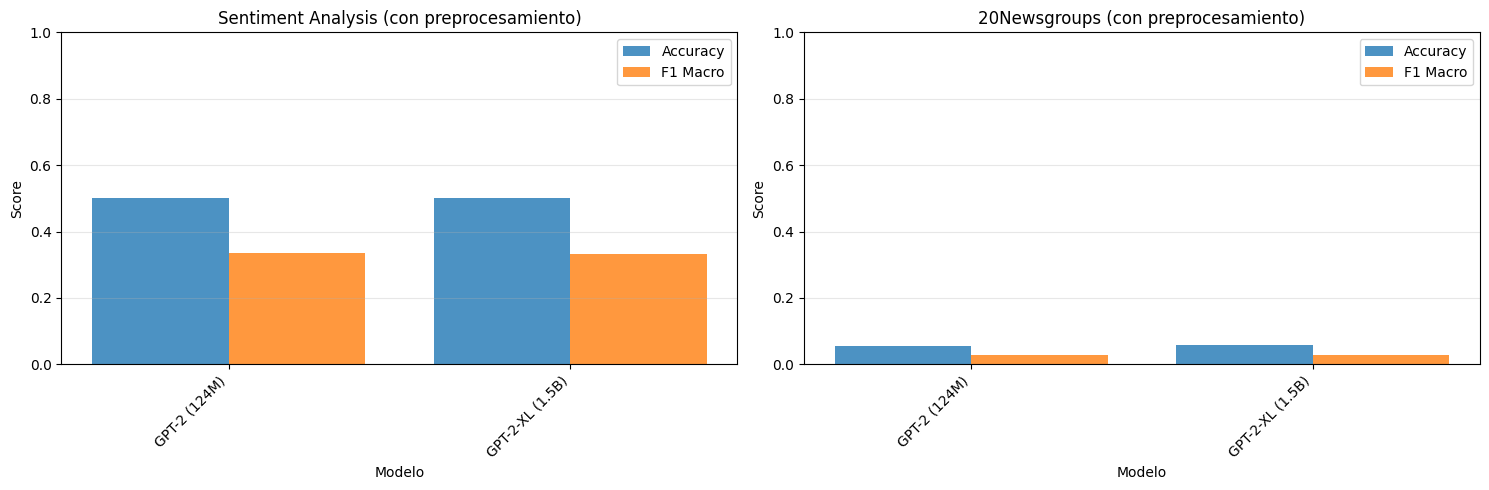


 Gráfico guardado en: comparison_preprocessed.png


In [ ]:
# Comparative plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sentiment Analysis
sentiment_data = df_comparison[df_comparison['Task'] == 'Sentiment']
x_pos = np.arange(len(sentiment_data))
axes[0].bar(x_pos - 0.2, sentiment_data['Accuracy'], 0.4, label='Accuracy', alpha=0.8)
axes[0].bar(x_pos + 0.2, sentiment_data['F1 Macro'], 0.4, label='F1 Macro', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Sentiment Analysis (with preprocessing)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(sentiment_data['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# 20Newsgroups
newsgroups_data = df_comparison[df_comparison['Task'] == '20Newsgroups']
x_pos = np.arange(len(newsgroups_data))
axes[1].bar(x_pos - 0.2, newsgroups_data['Accuracy'], 0.4, label='Accuracy', alpha=0.8)
axes[1].bar(x_pos + 0.2, newsgroups_data['F1 Macro'], 0.4, label='F1 Macro', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('20Newsgroups (with preprocessing)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(newsgroups_data['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('outputs/comparison_preprocessed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as: comparison_preprocessed.png")
